In [1]:
# load the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LOAD THE DATASET

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   171M      0  0:00:04  0:00:04 --:--:--  171M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip

In [4]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [5]:
!ls PetImages

Cat  Dog


**FILTERING CORRUPTED IMAGES**

In [6]:
# Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**GENERATE THE DATASET WITH KERAS UTILITY**

In [7]:
# fixing the image size for whole processing
image_size = (180, 180)
# specifying the batch size
batch_size = 32

# Generating the TRAINING & TESTING DATSET with 80% - 20% SPLIT
# Generating the TRAINING dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

#  Generating the VALIDATION dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# VISUALIASING THE DATSET


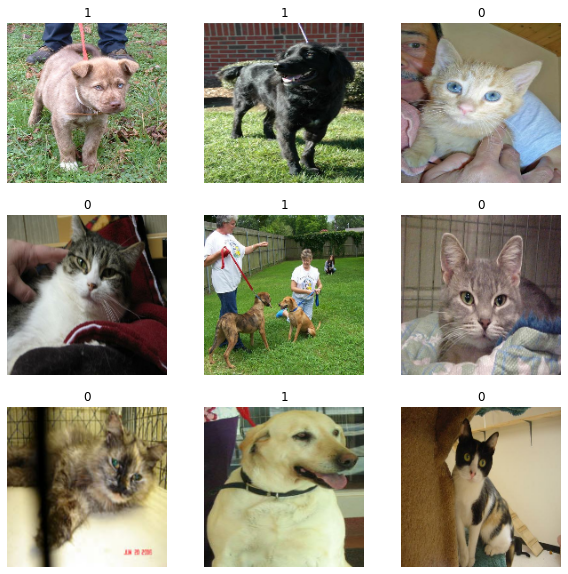

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Augmenting the Datset

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

**VISUALISE THE AUGMENTED DATA**

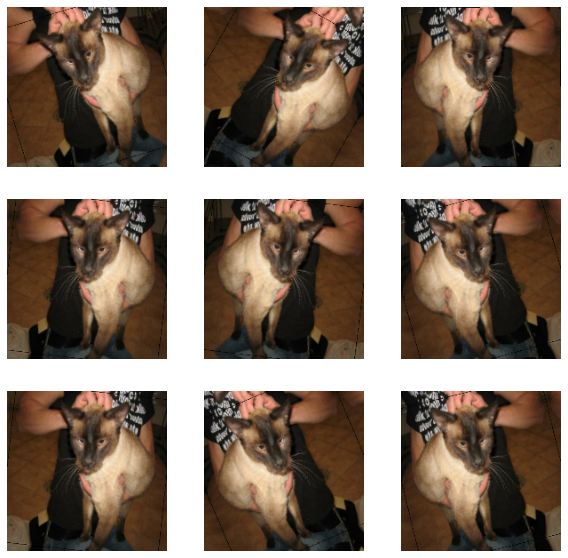

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**STANDARDISING THE DATA**

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

*WE WILL MAKE IT PART OF THE MODEL ITSELF*

**CONFIGURING THE DATASET**

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

**BUILD THE MODEL**

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

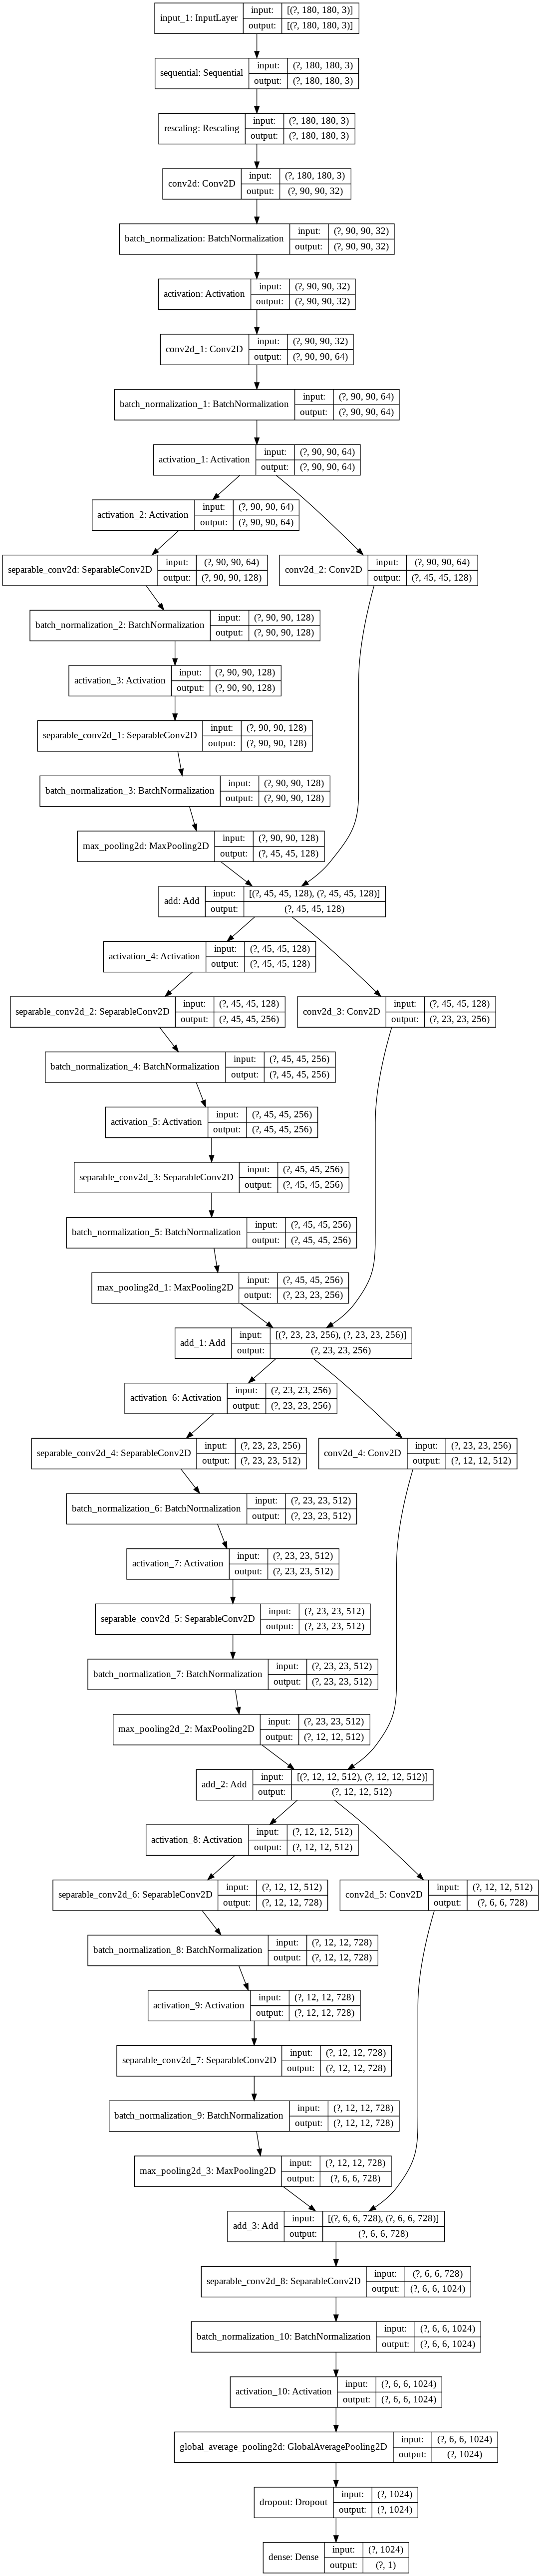

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

TRAINING THE MODEL

In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 155s 265ms/step - loss: 0.6205 - accuracy: 0.6665 - val_loss: 1.0223 - val_accuracy: 0.5199
Epoch 2/50
586/586 [==============================] - 157s 269ms/step - loss: 0.4436 - accuracy: 0.7949 - val_loss: 0.8618 - val_accuracy: 0.6871
Epoch 3/50
586/586 [==============================] - 157s 268ms/step - loss: 0.3617 - accuracy: 0.8387 - val_loss: 0.3818 - val_accuracy: 0.8358
Epoch 4/50
586/586 [==============================] - 157s 268ms/step - loss: 0.3047 - accuracy: 0.8706 - val_loss: 0.2298 - val_accuracy: 0.9079
Epoch 5/50
586/586 [==============================] - 157s 268ms/step - loss: 0.2530 - accuracy: 0.8959 - val_loss: 0.2776 - val_accuracy: 0.8770
Epoch 6/50
586/586 [==============================] - 157s 268ms/step - loss: 0.2156 - accuracy: 0.9102 - val_loss: 0.4893 - val_accuracy: 0.8150
Epoch 7/50
586/586 [==============================] - 157s 268ms/step - loss: 0.2006 - accuracy: 0.9179 - val_loss: 0.2173 -

TESTING ON NEW DATA

In [14]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 95.42 percent cat and 4.58 percent dog.
